# CoV-19 Preprocessing & Prediction 

## Mehrdad Heshmat

### Section 1: Importing Required Libraries

In [1]:
import pandas as pd
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline
pd.set_option("display.max_rows",None,"display.max_columns",None)


### Initializing output-paths:

In [2]:
import os
if not os.path.isdir(".\\output") or not os.path.isdir(".\\output\\charts"):
    try:
        os.makedirs(".\\output\\charts")
        os.makedirs(".\\output\\preprocessed_Dataframe")
        
    except FileExistsError:
        print(FileExistsError)

### Section 2: Loading the Data & Exploring It

In [3]:
df  = pd.read_csv(".\SARS-CoV-2_Dataset_main.csv")

In [4]:
df.shape

(136993, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136993 entries, 0 to 136992
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   iso_code                 136993 non-null  object 
 1   continent                128272 non-null  object 
 2   location                 136993 non-null  object 
 3   date                     136993 non-null  object 
 4   total_cases              129343 non-null  float64
 5   total_deaths             118074 non-null  float64
 6   total_vaccinations       35518 non-null   float64
 7   people_vaccinated        33930 non-null   float64
 8   people_fully_vaccinated  30968 non-null   float64
 9   new_cases                129338 non-null  float64
 10  new_deaths               118270 non-null  float64
 11  population               136013 non-null  float64
dtypes: float64(8), object(4)
memory usage: 12.5+ MB


# Preprocessing 

### Task1:


In [6]:
df['total_vaccinations']=df['total_vaccinations'].fillna(0)
df['people_vaccinated']=df['people_vaccinated'].fillna(0)
df['people_fully_vaccinated']=df['people_fully_vaccinated'].fillna(0)
df['new_cases']=df['new_cases'].fillna(0)
df['new_deaths']=df['new_deaths'].fillna(0)


In [7]:
df = df[df.location != 'International']
df = df[df.location !=  'Northern Cyprus']

In [8]:
countries_set = set(df.location)
for cont in countries_set:
    df.loc[(df.location == cont) ,'people_fully_vaccinated' ]=df.loc[(df.location == cont)]['people_fully_vaccinated'].replace(0 ,method='ffill')
    df.loc[(df.location == cont) ,'total_vaccinations' ]=df.loc[(df.location == cont)]['total_vaccinations'].replace(0 ,method='ffill')


In [9]:
df.to_csv('output\\preprocessed_Dataframe\\' + 'preprocessed_df-Stage 1.csv')

### Task3:

In [10]:
df.date = pd.to_datetime(df.date, format='%m/%d/%Y')

### Task2 (not in this project):

### Saving Preprocessed DataFrame

In [11]:
df['total_deaths']=df['total_deaths'].fillna(method="ffill")
df['total_cases']=df['total_cases'].fillna(method="ffill")

# countries_set = set(df.location)
# for cont in countries_set:
#     df.loc[(df.location == cont) ,'total_cases' ]=df.loc[(df.location == cont)]['total_cases'].fillna(method='ffill')
#     df.loc[(df.location == cont) ,'total_deaths' ]=df.loc[(df.location == cont)]['total_deaths'].fillna(method='ffill')


In [12]:
df.to_csv('output\\preprocessed_Dataframe\\' + 'preprocessed_SARS-CoV-2_Dataset_main.csv')

# Prediction

### Importing Required Libraries

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation

# Libraries required for making, displaying, and exporting the image of decision tree. 
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#others

import datetime

In [14]:
df  = pd.read_csv(".\\output\\preprocessed_Dataframe\preprocessed_SARS-CoV-2_Dataset_main.csv")

In [15]:
def tree_predict_country(country,targ,day):
    
    current_df = df[df.location==country].copy()
    current_df['date'] = pd.to_datetime(current_df['date'])  
    feature_cols = ['total_cases','total_deaths','total_vaccinations','people_fully_vaccinated','new_cases','new_deaths','population']
    feature_cols = set(feature_cols) - set([targ])
    
    
    train_start_date = current_df.date.iloc[0]
    train_end_date = datetime.datetime(2021,10,31)
    
    
    test_start_date =  datetime.datetime(2021,11,1)
#     test_end_date  =  datetime.datetime(2021,11,30)
    test_end_date = datetime.datetime(2021,10,31) + datetime.timedelta(days=day)

    
    
    
    train_mask = (current_df['date'] > train_start_date) & (current_df['date'] <= train_end_date)
    test_mask = (current_df['date'] > test_start_date) & (current_df['date'] <= test_end_date)
    
    train_df = current_df.loc[train_mask]
    test_df = current_df.loc[test_mask]
    
    predicted_df = test_df.copy()
    predicted_df = predicted_df.drop(targ,axis=1)
    x_test = test_df[feature_cols]
    y_test =  test_df[targ]
    
#     if len(x_test) == 0 or len(y_test)==0:
#         return
    
    X = train_df[feature_cols] # Features
    Y = train_df[targ] # Target variable
    
    
    
    tree = DecisionTreeRegressor(criterion='squared_error', max_depth=12)
    
    tree = tree.fit(X,Y)
    y_pred = tree.predict(x_test)
    
    
    predicted_df[targ] = y_pred
    
#     print(predicted_df.head())
    
#     print(f"Country: {country}   Target: {targ}   Days: {day}   MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    fig = predicted_df.plot(x='date',y=targ, title=f"Country: {country}   Target: {targ}   Days: {day}   MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    fig.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    # added
    fig.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    # set formatter
    # set font and rotation for date tick labels
    plt.gcf().autofmt_xdate()
    #plt.savefig('output\\charts\\' + 'people_fully_vaccinated-people_vaccinated-total_vaccinations__'+country+'.png')
    plt.show()

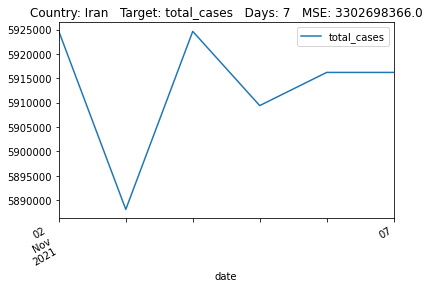

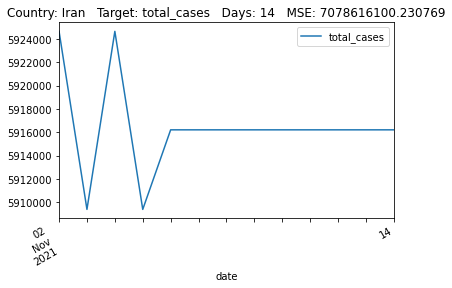

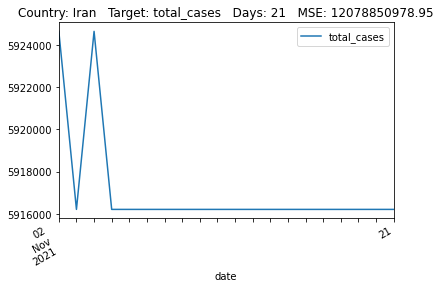

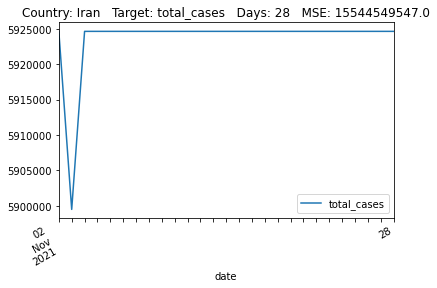

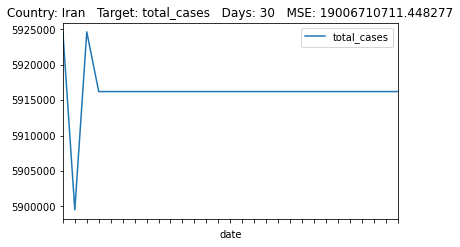

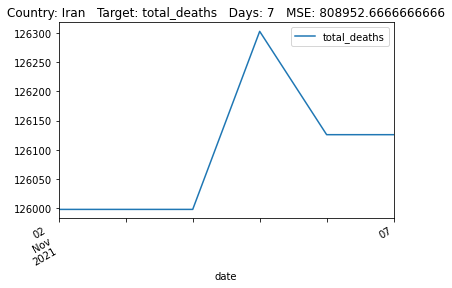

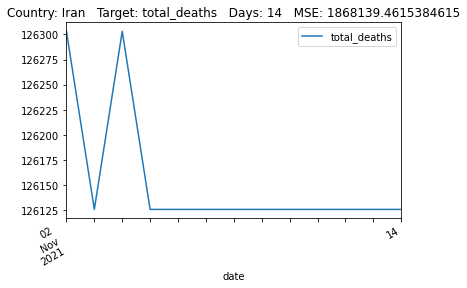

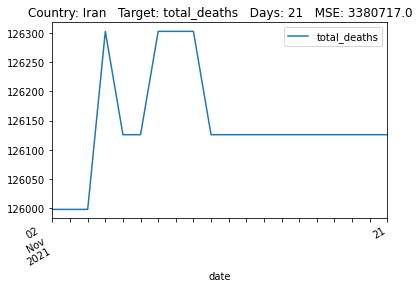

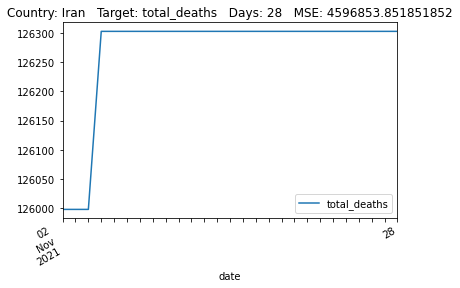

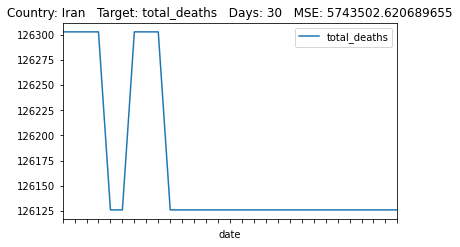

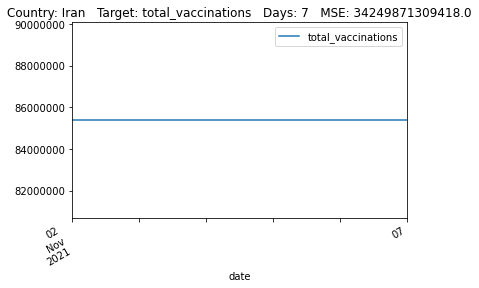

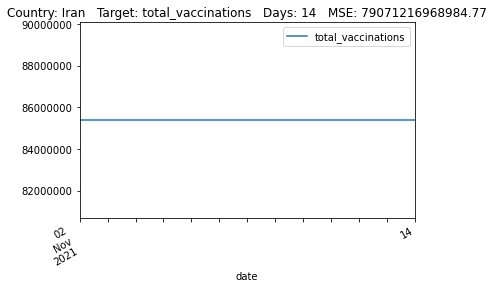

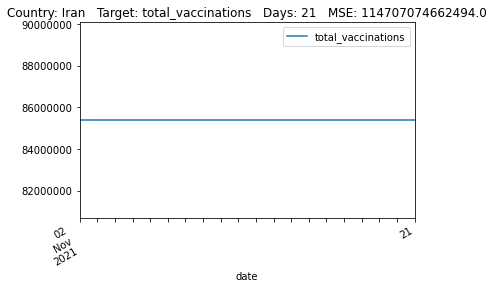

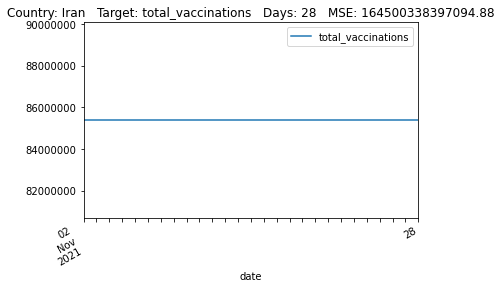

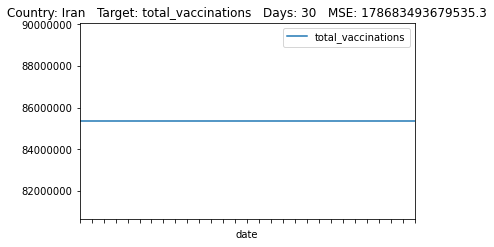

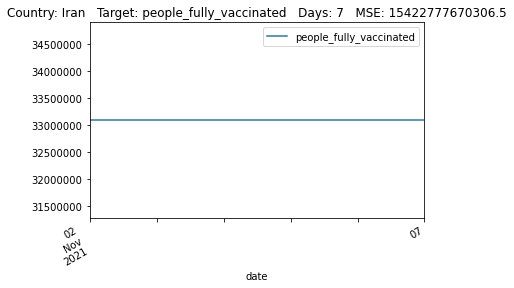

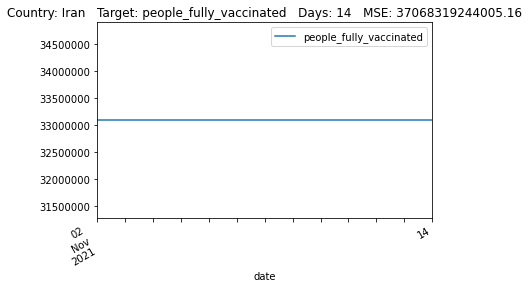

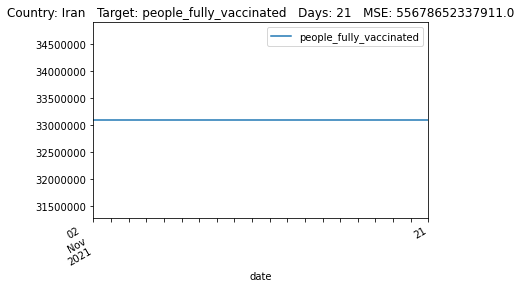

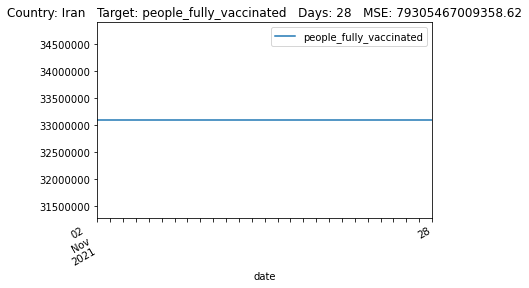

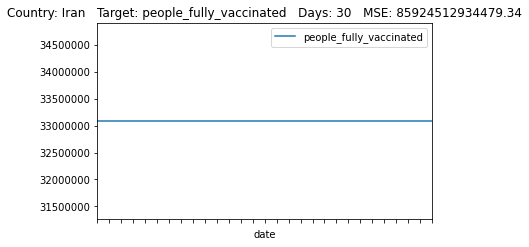

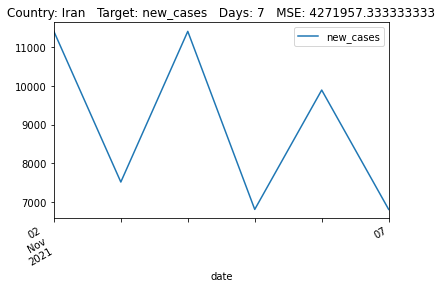

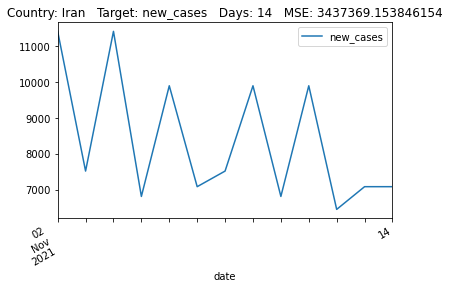

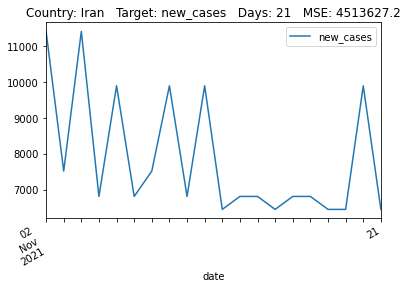

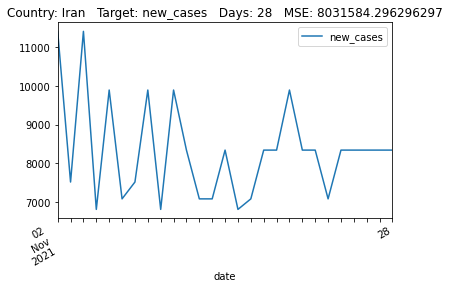

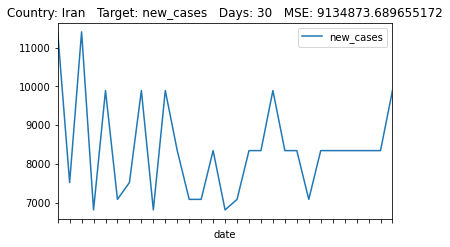

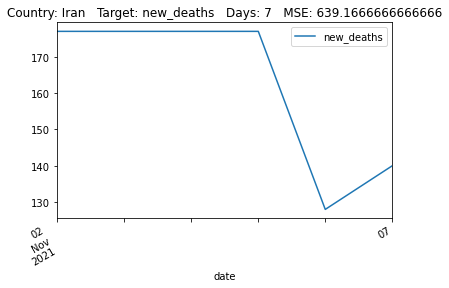

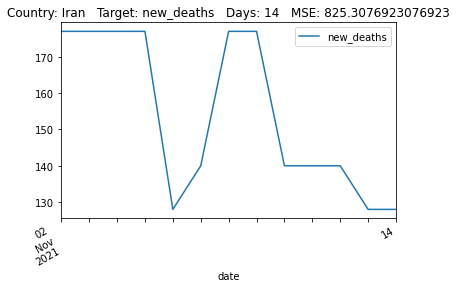

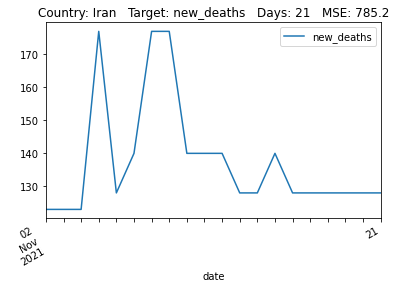

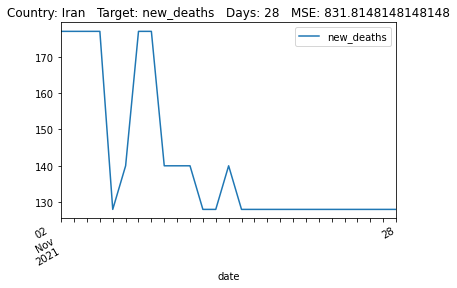

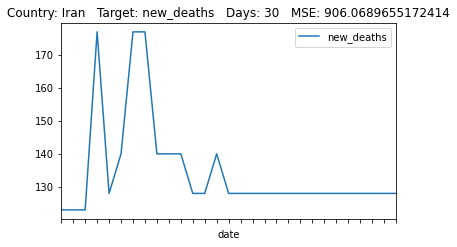

In [16]:
days = [7,14,21,28,30]
countries_df = pd.DataFrame()
for country in set(['Iran']):
    for target in ['total_cases','total_deaths','total_vaccinations','people_fully_vaccinated','new_cases','new_deaths']:
        for day in days:
            tree_predict_country(country,target,day)
        



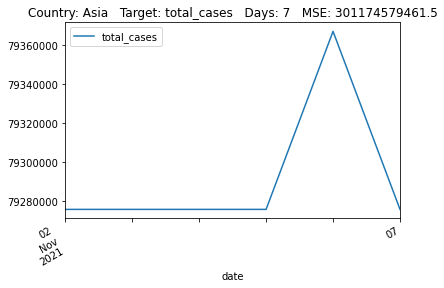

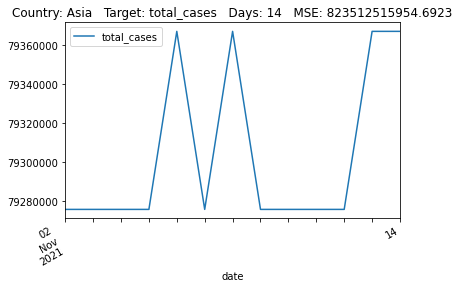

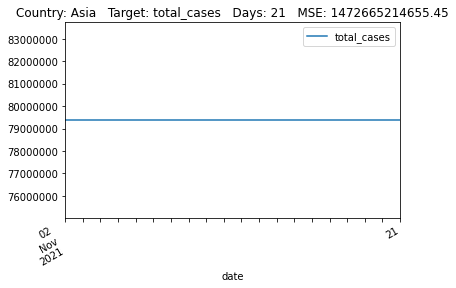

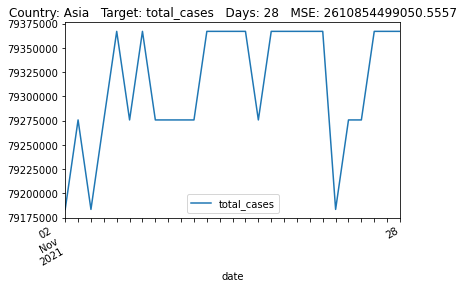

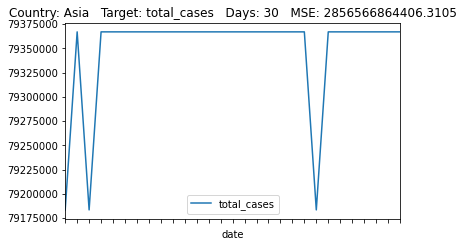

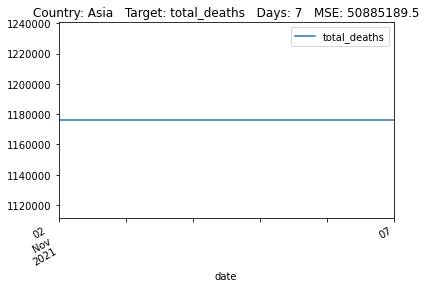

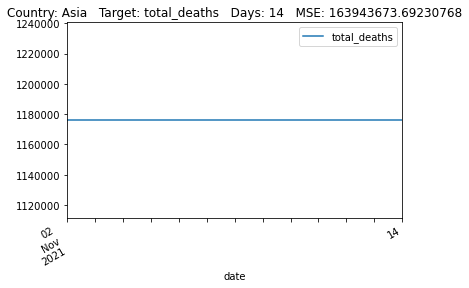

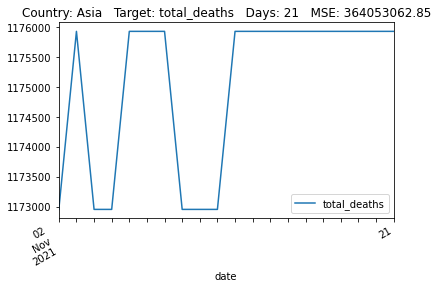

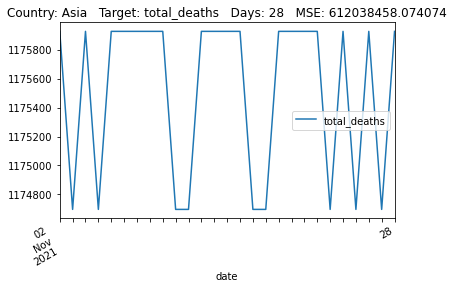

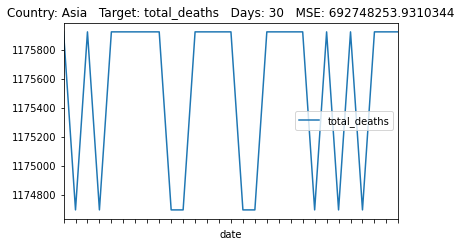

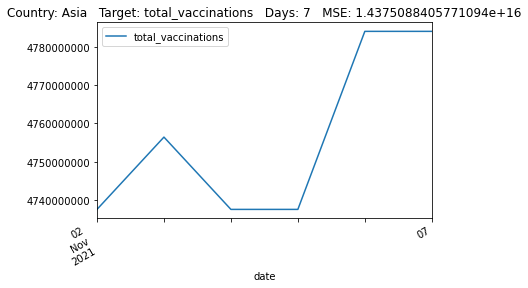

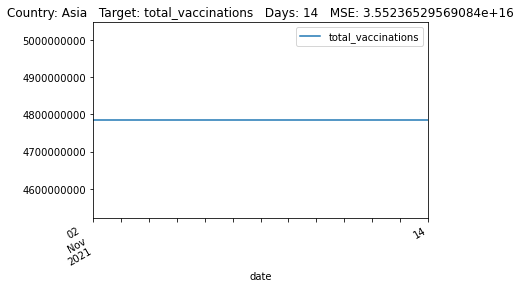

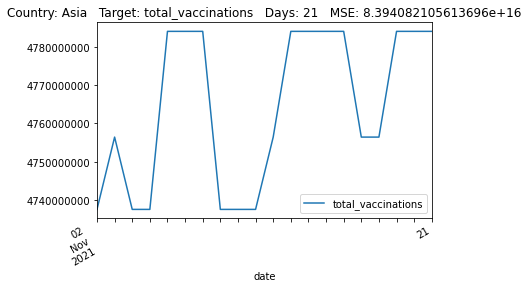

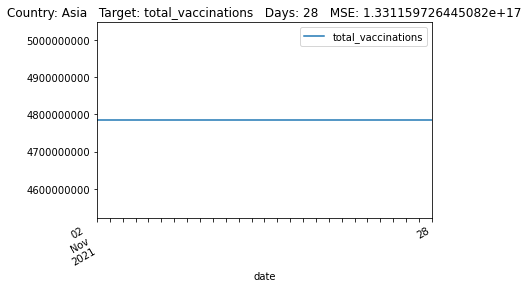

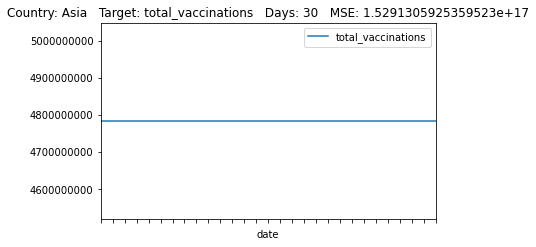

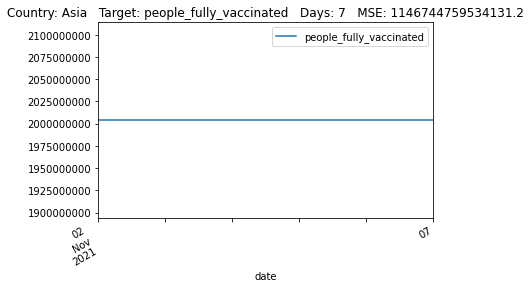

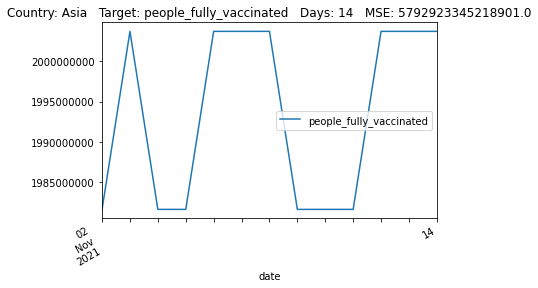

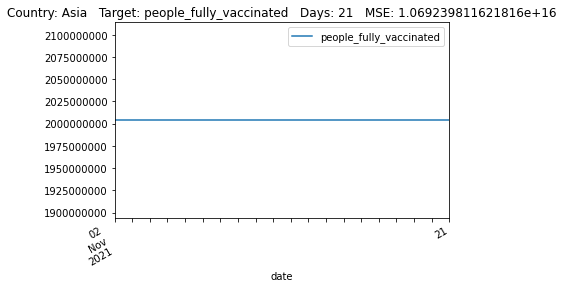

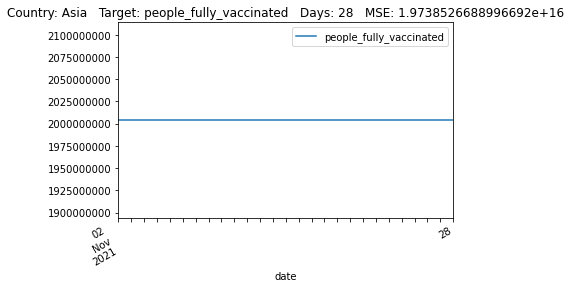

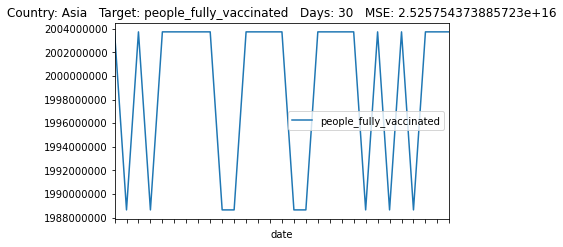

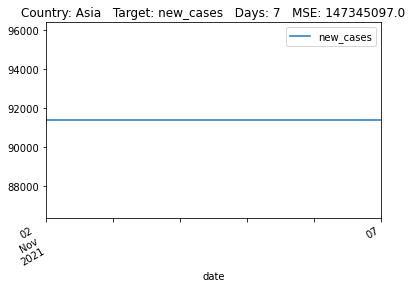

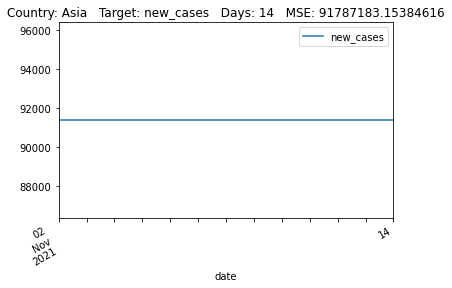

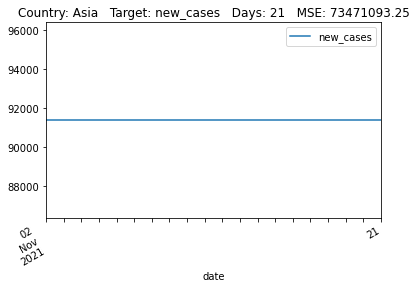

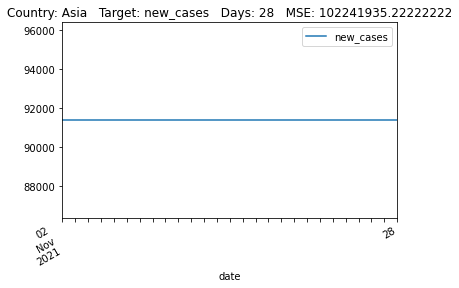

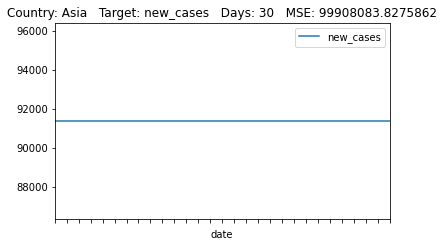

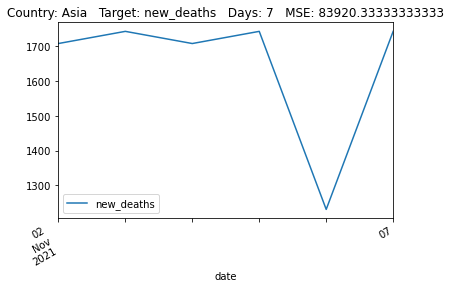

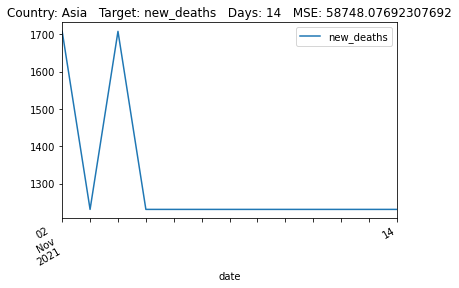

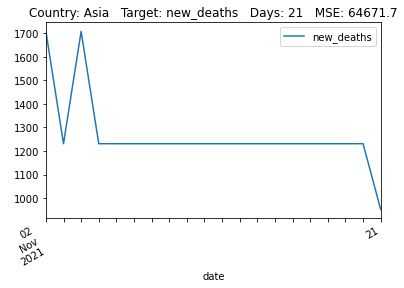

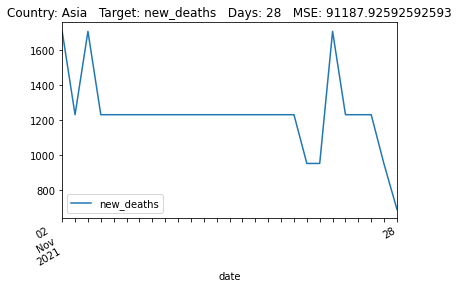

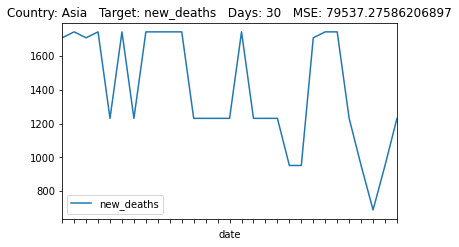

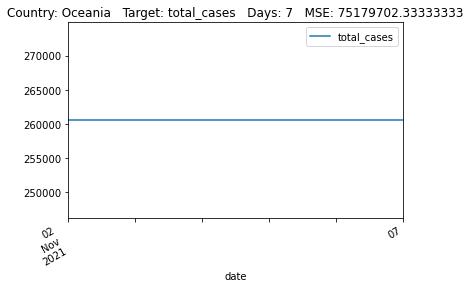

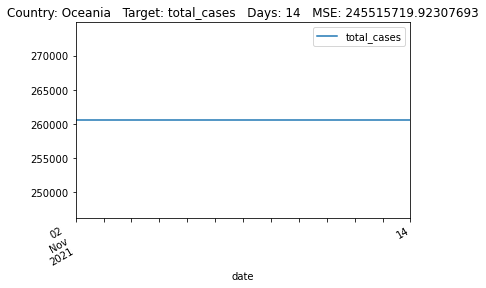

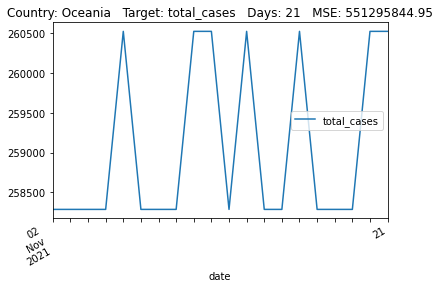

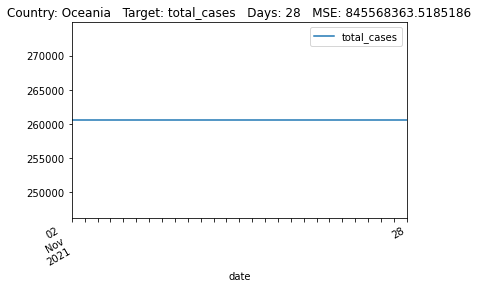

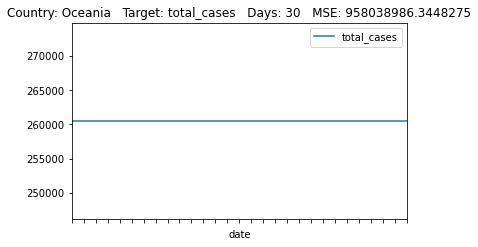

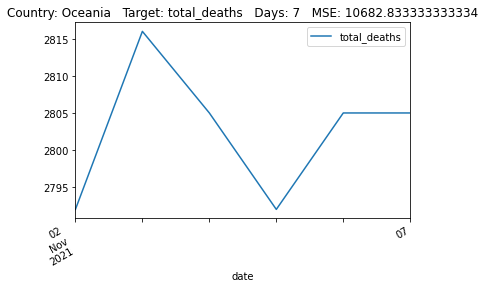

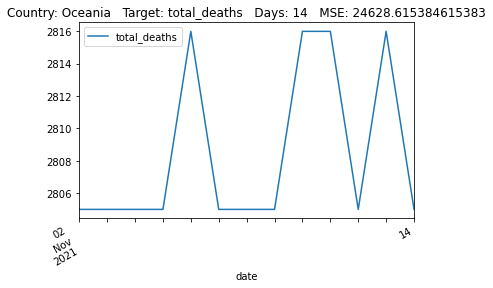

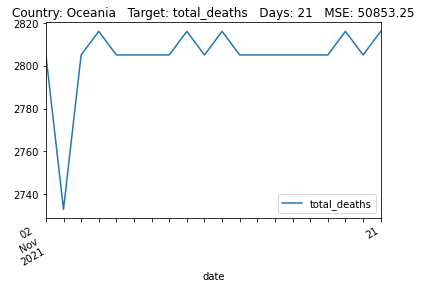

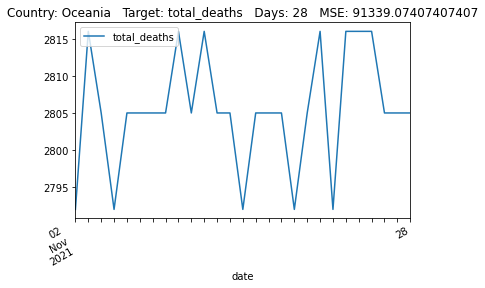

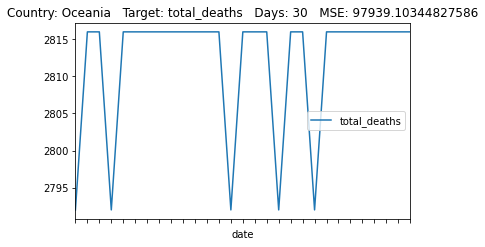

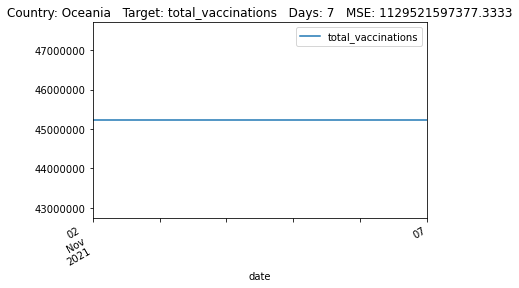

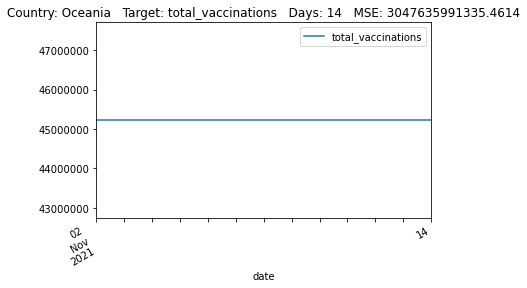

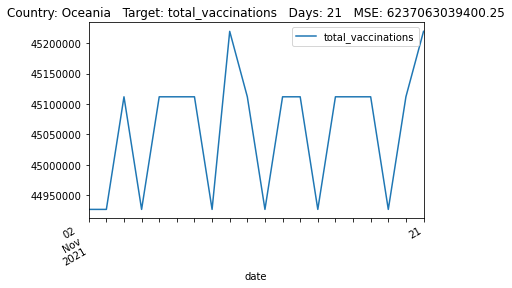

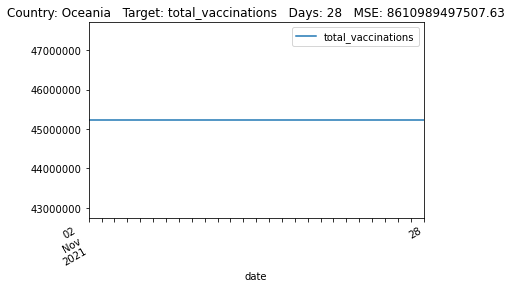

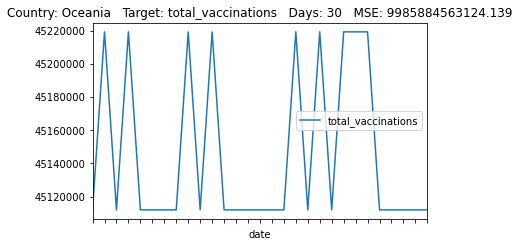

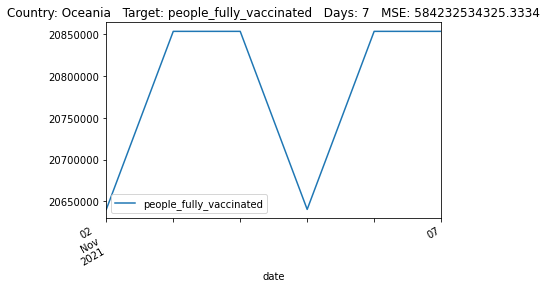

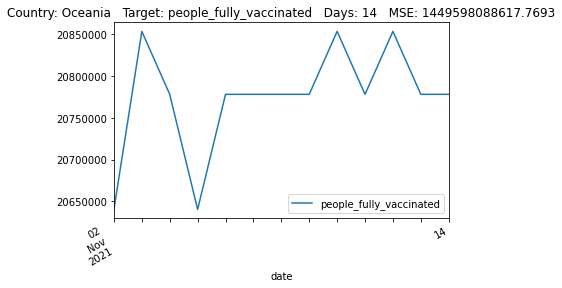

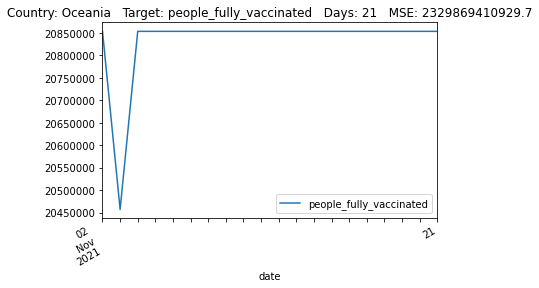

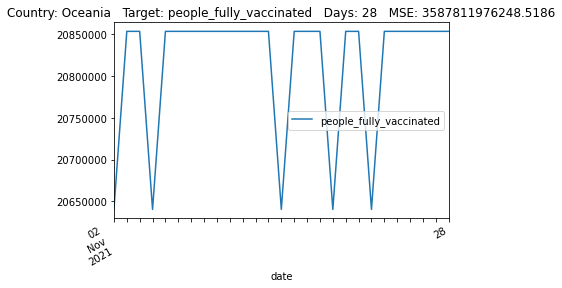

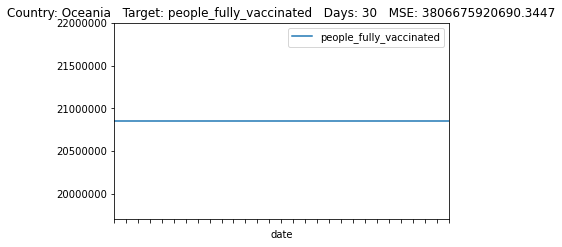

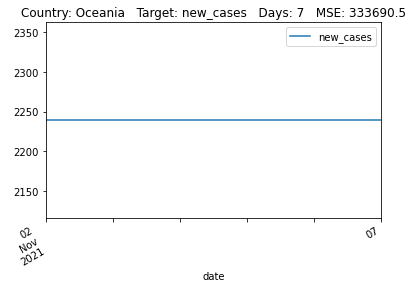

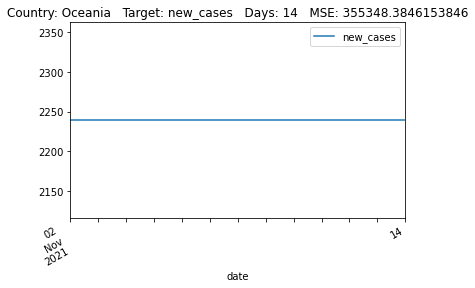

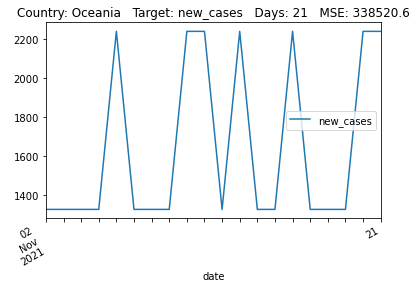

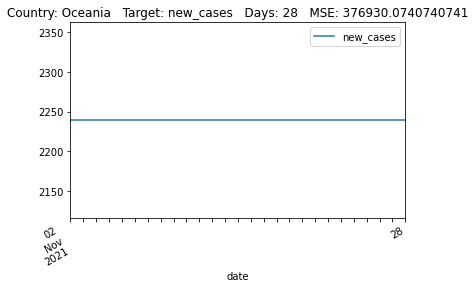

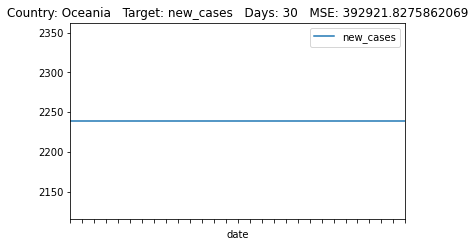

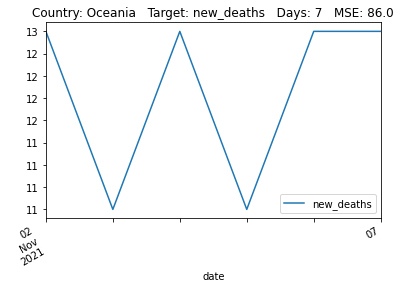

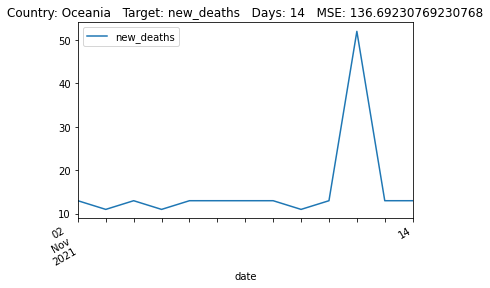

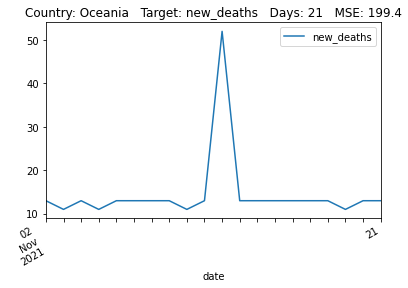

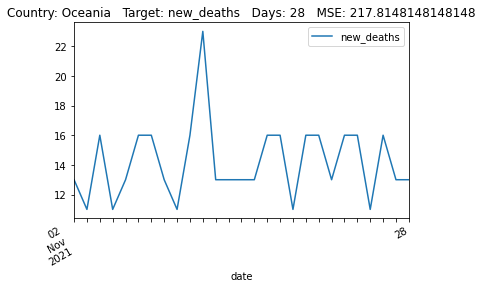

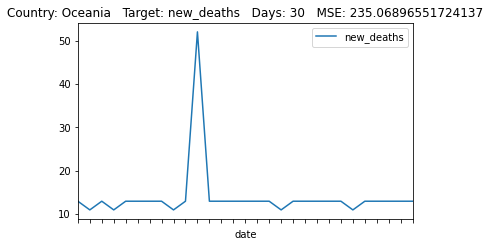

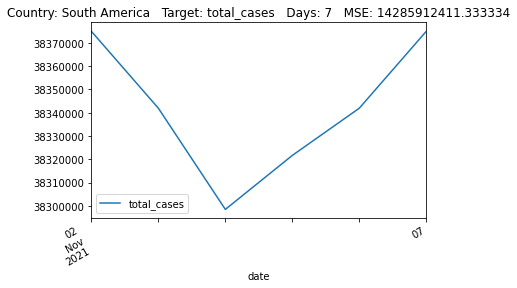

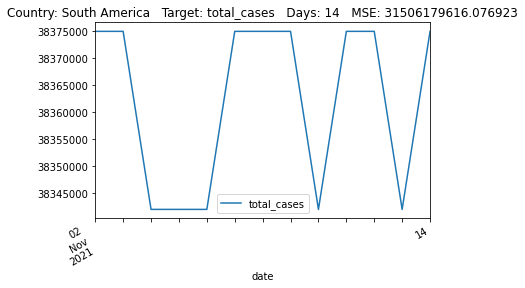

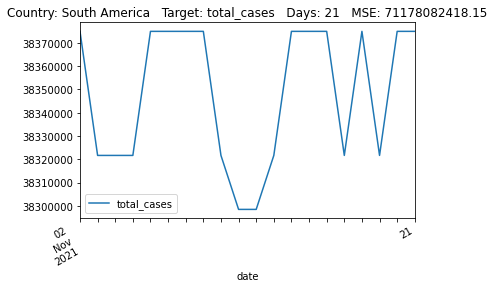

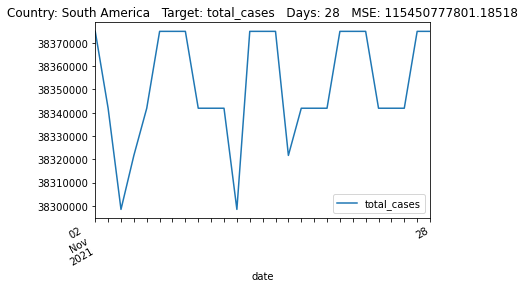

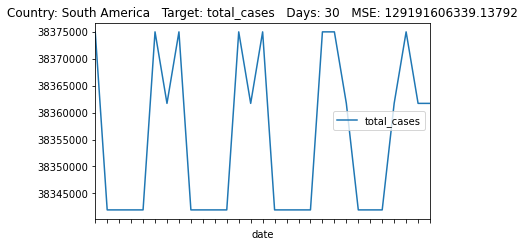

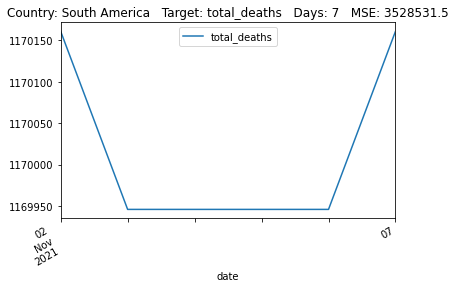

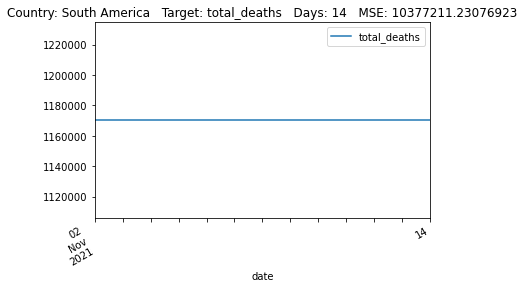

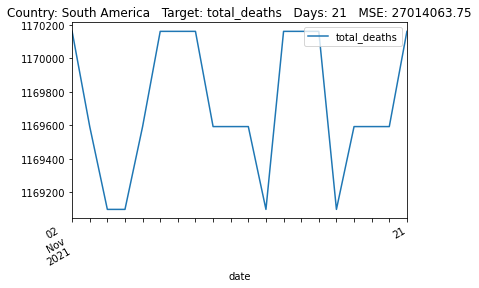

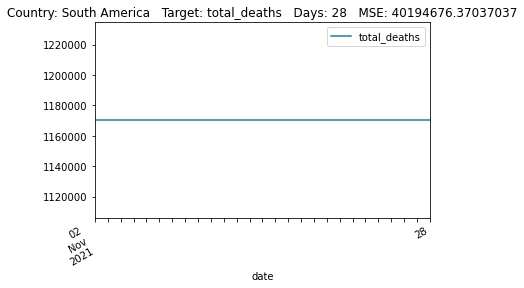

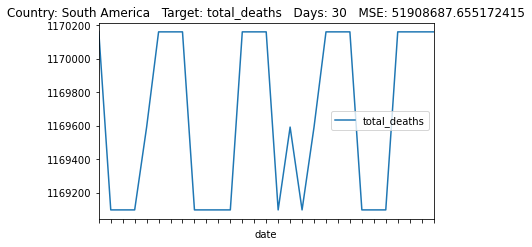

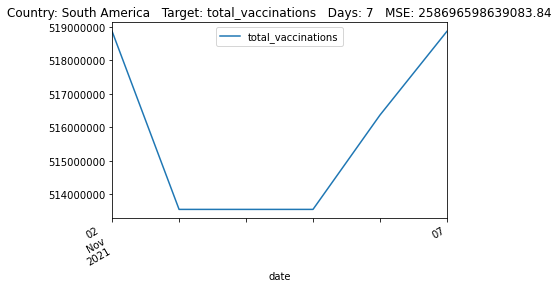

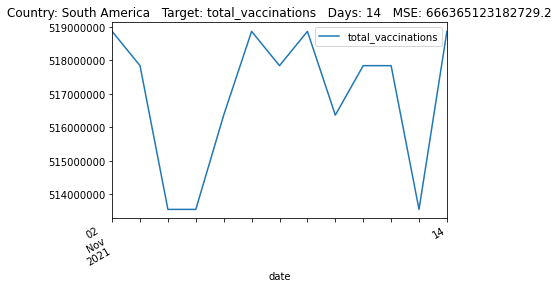

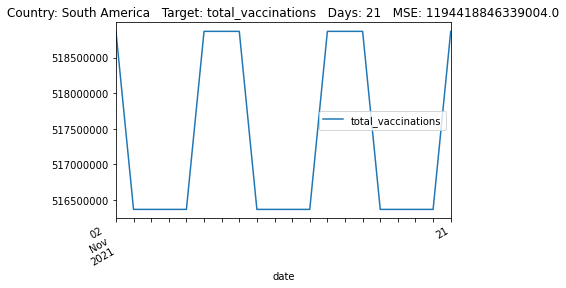

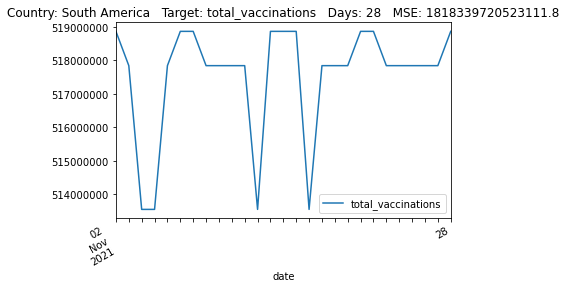

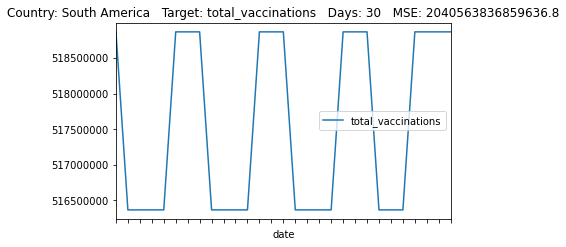

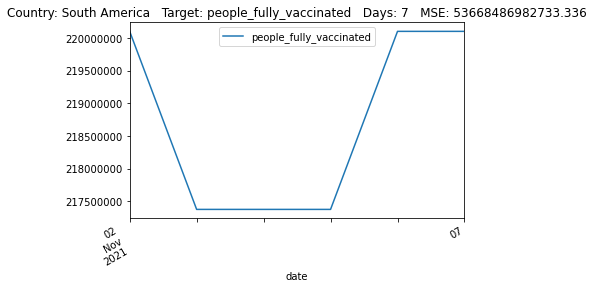

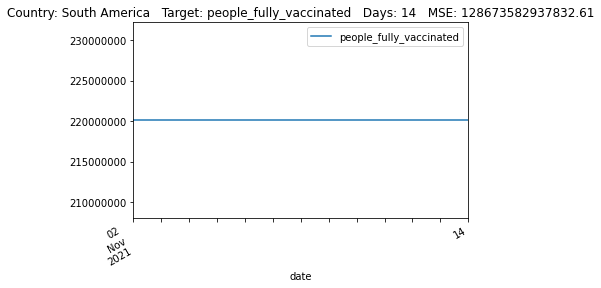

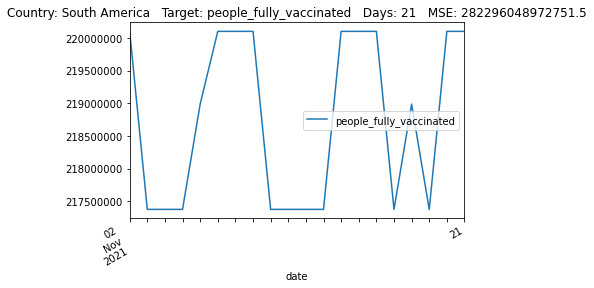

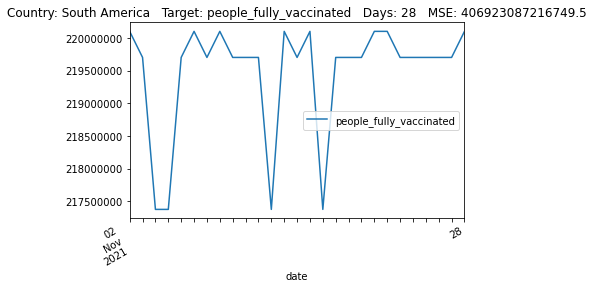

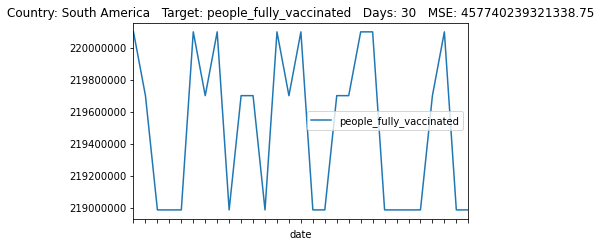

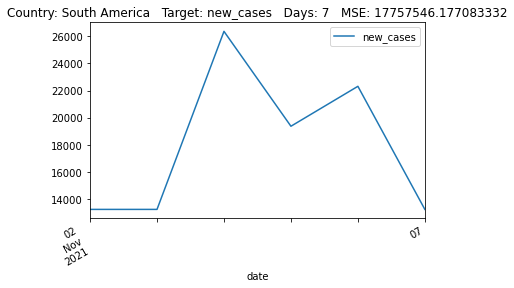

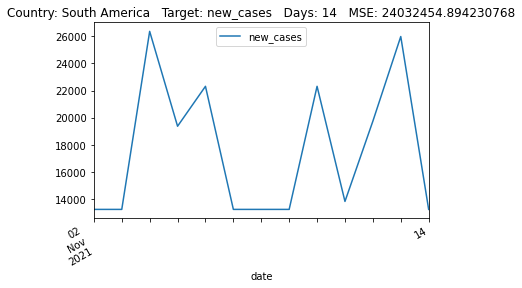

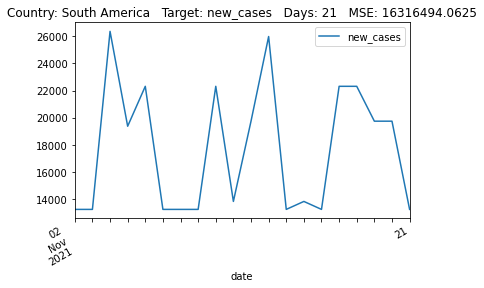

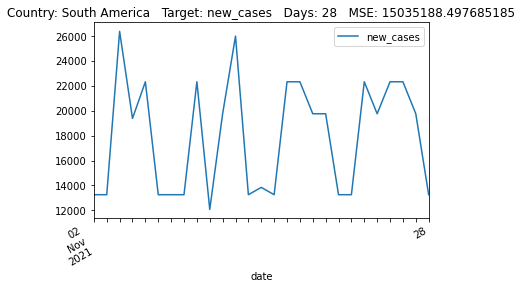

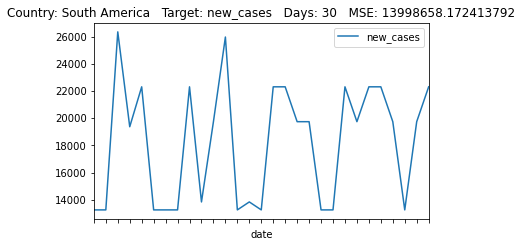

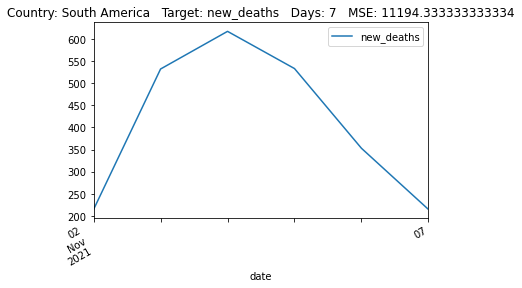

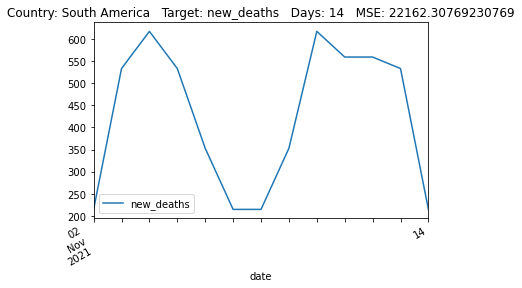

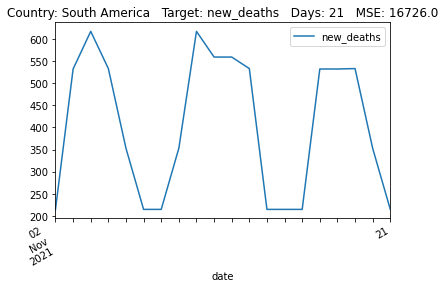

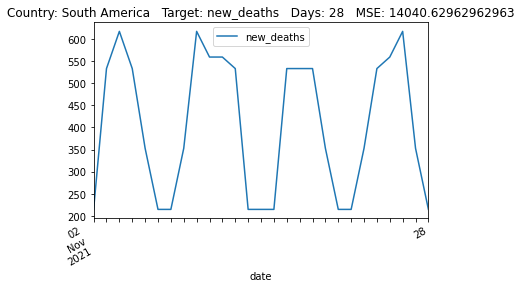

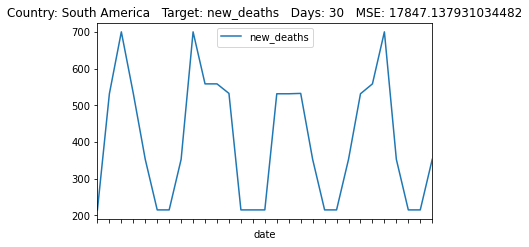

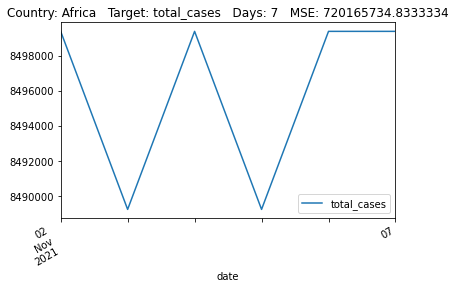

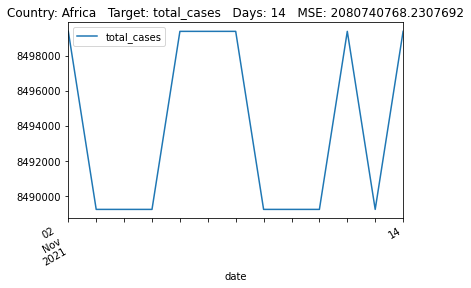

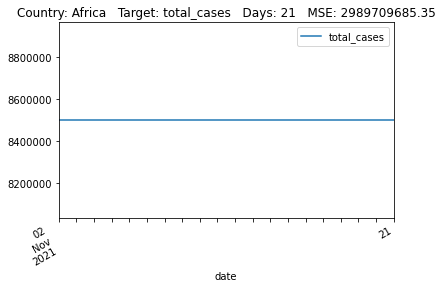

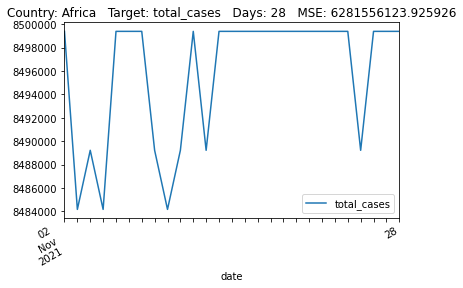

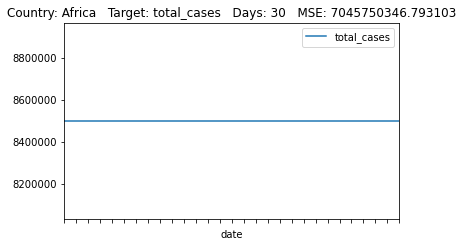

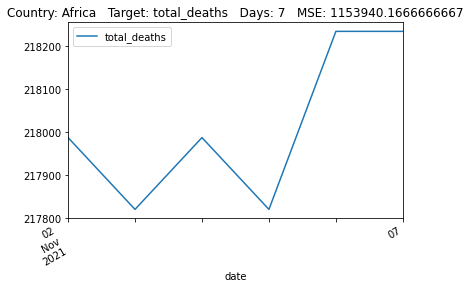

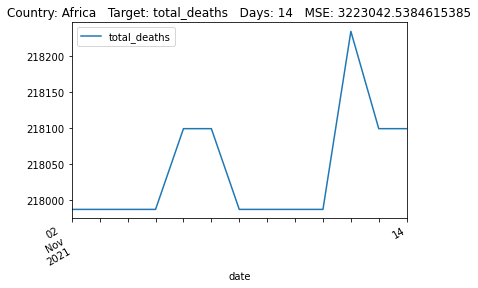

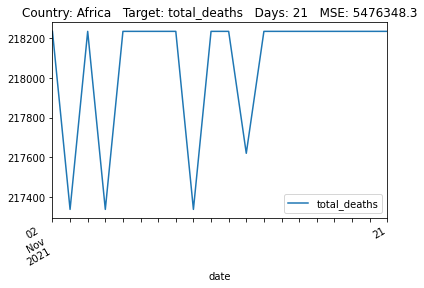

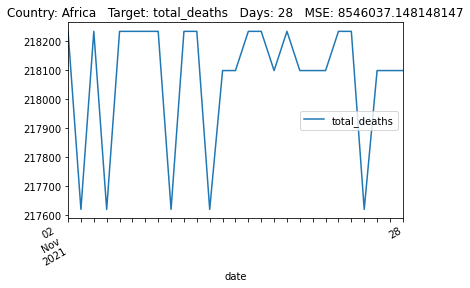

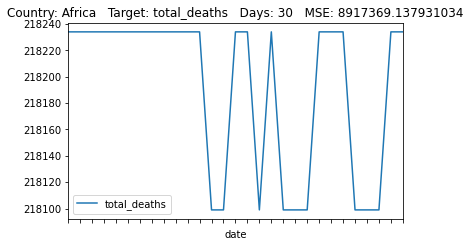

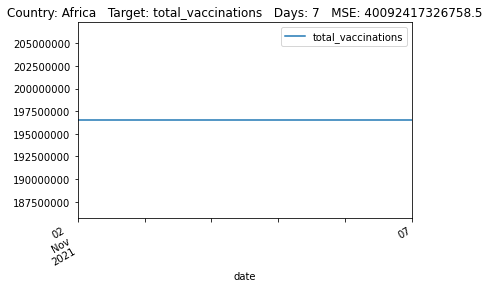

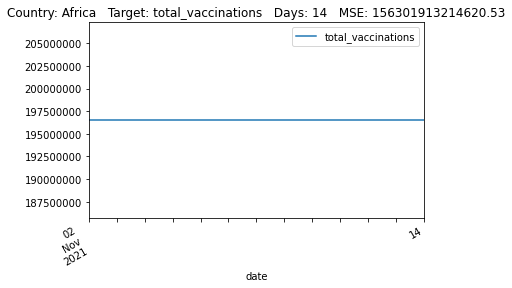

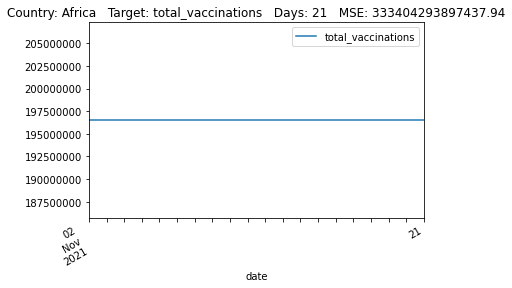

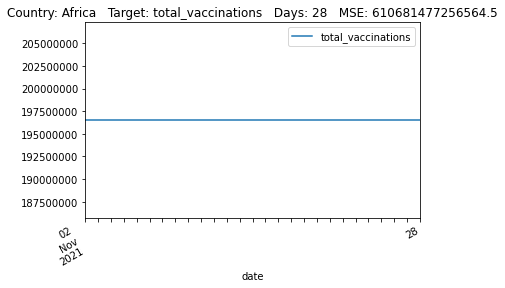

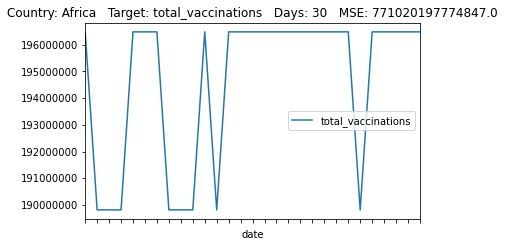

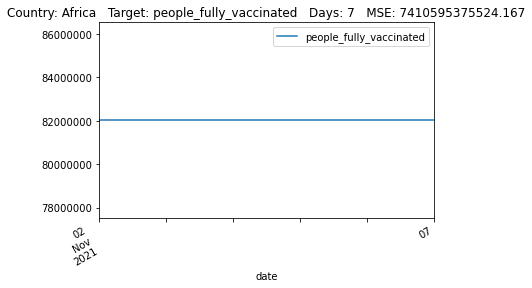

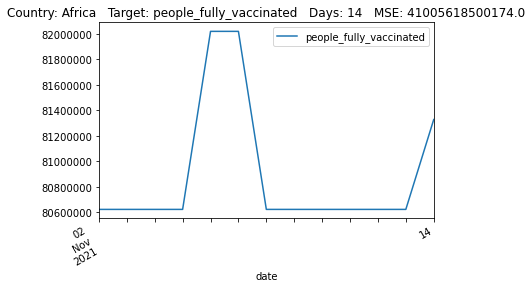

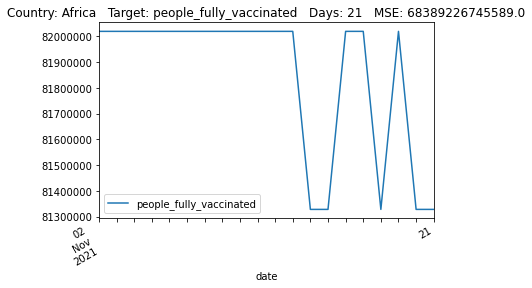

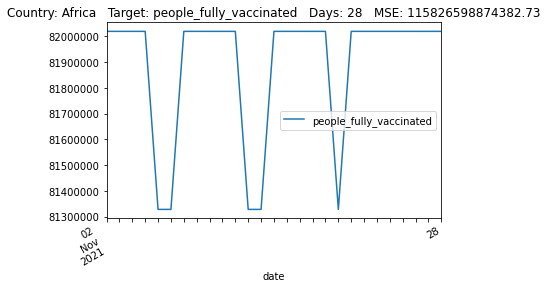

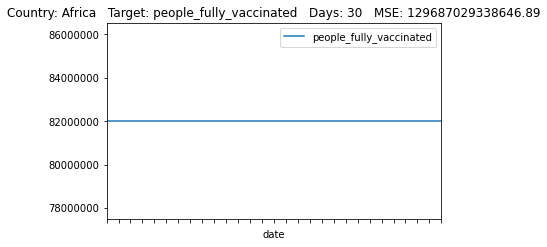

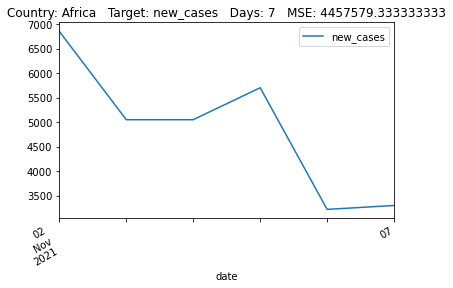

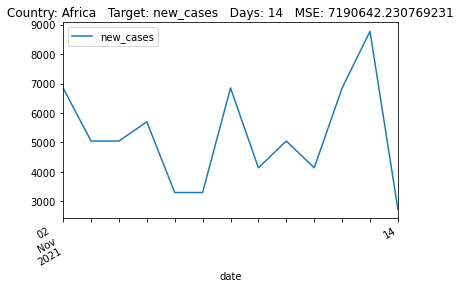

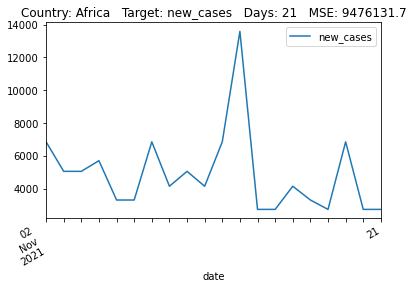

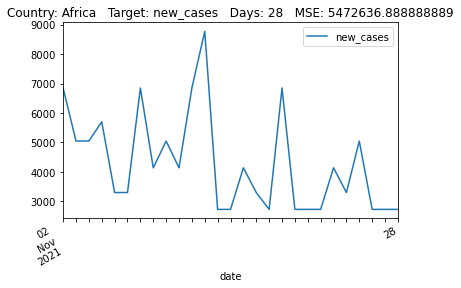

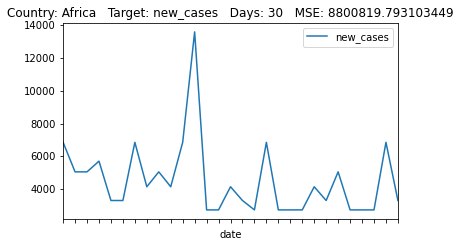

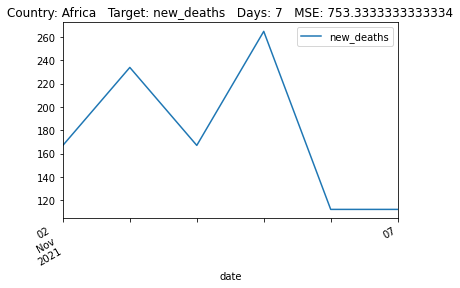

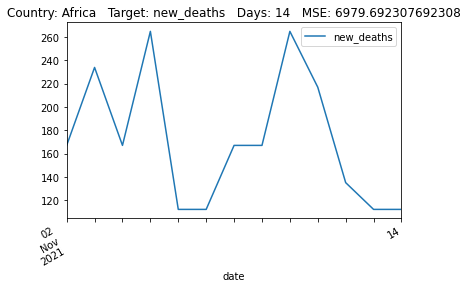

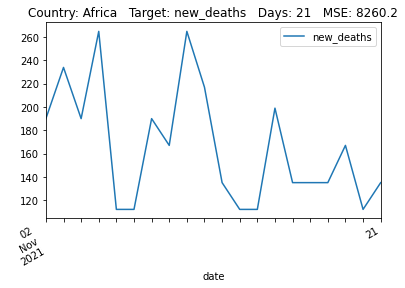

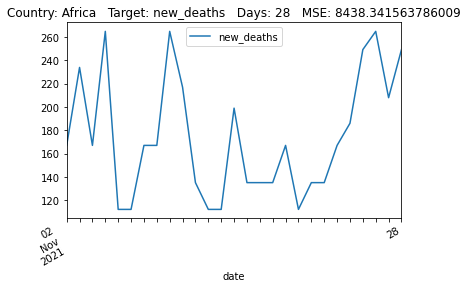

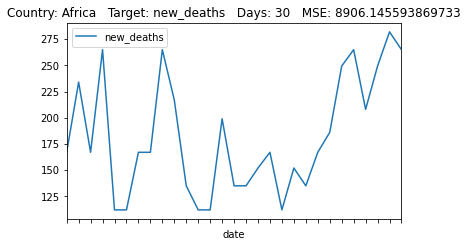

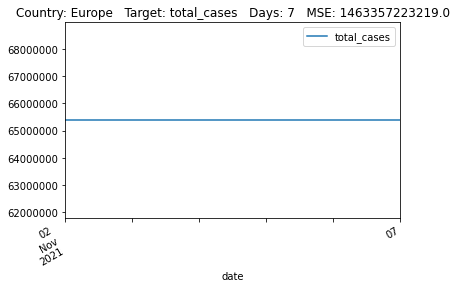

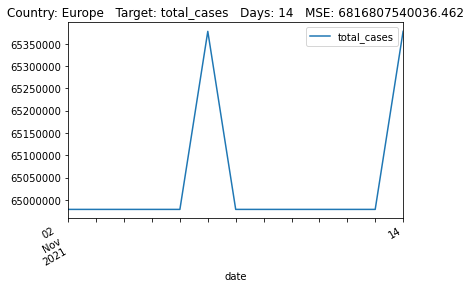

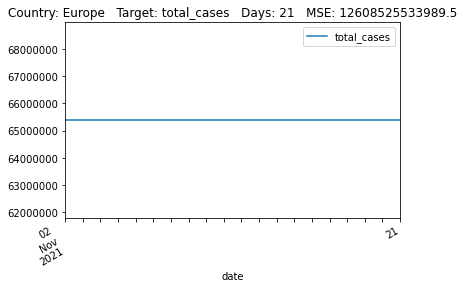

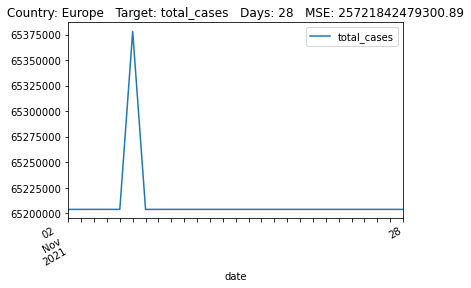

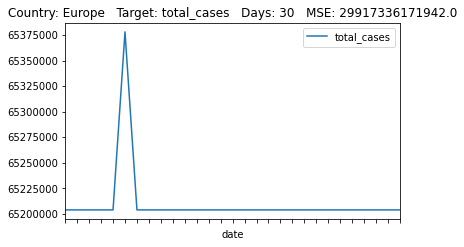

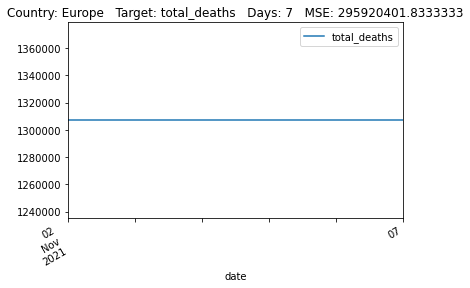

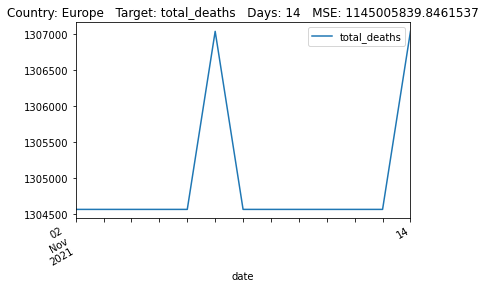

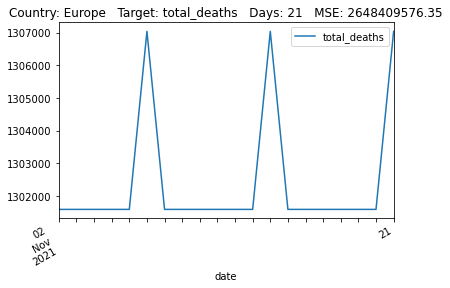

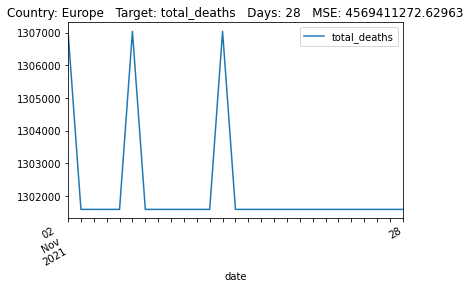

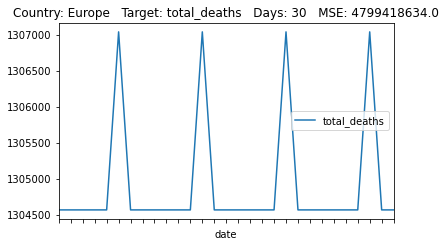

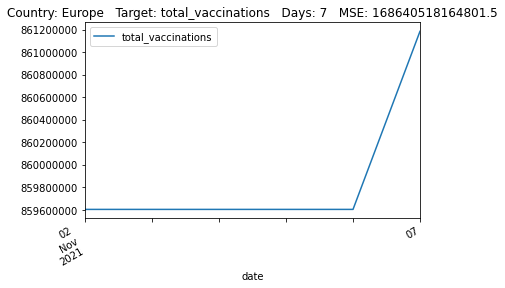

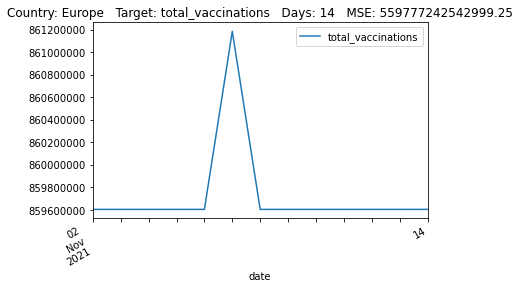

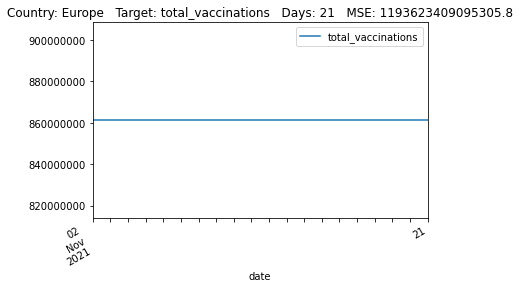

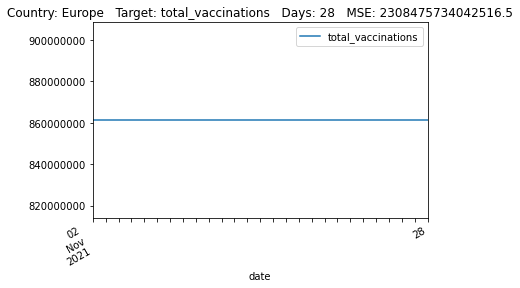

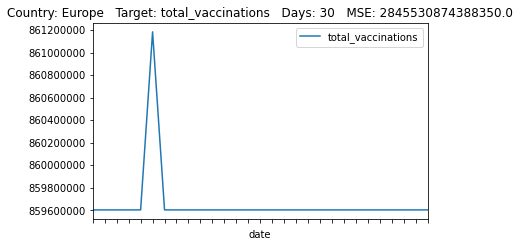

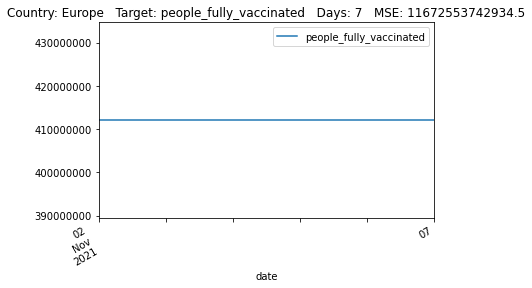

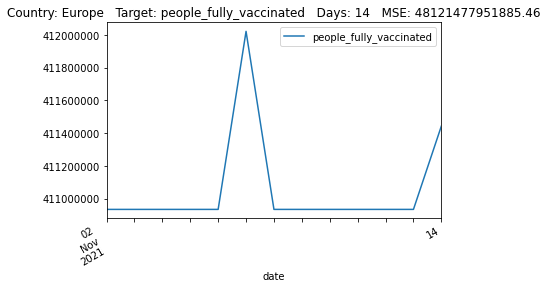

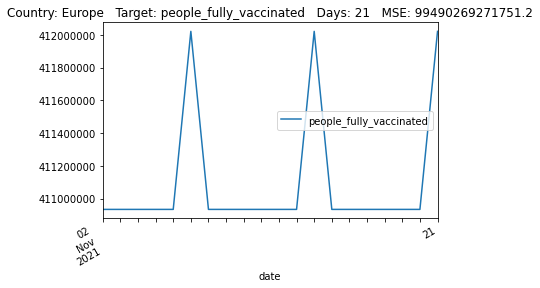

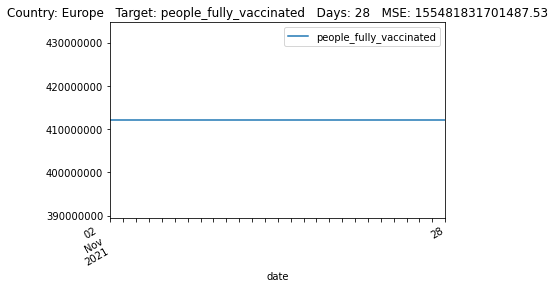

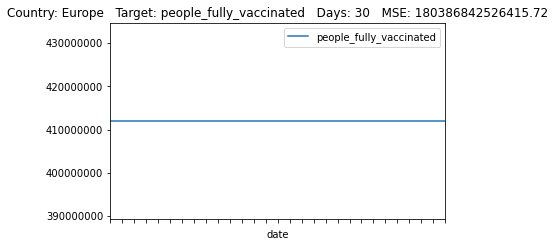

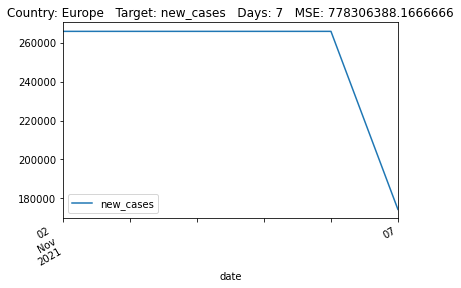

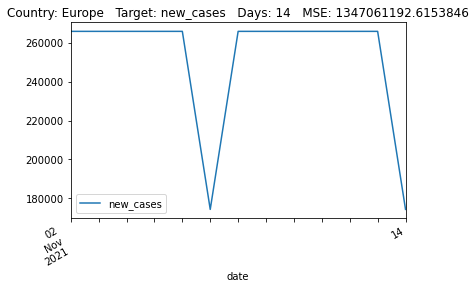

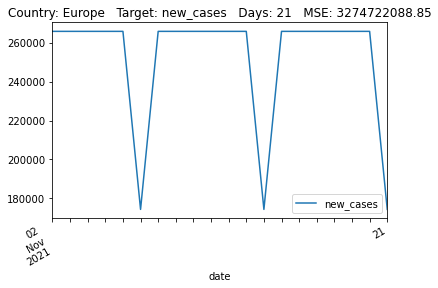

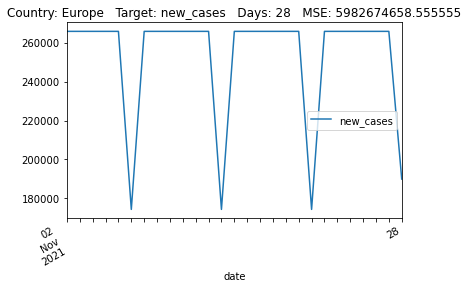

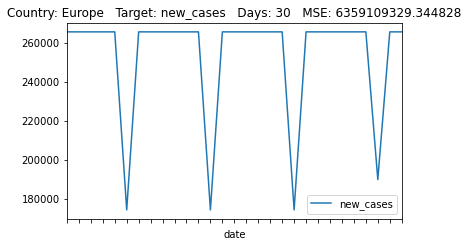

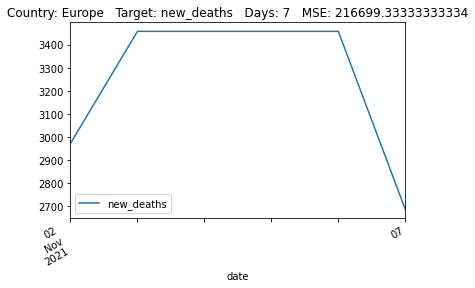

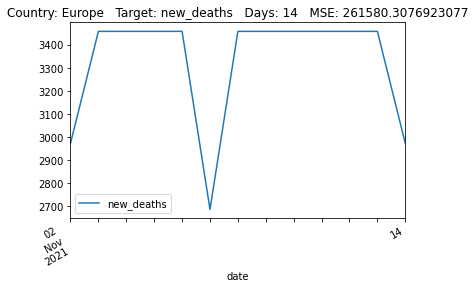

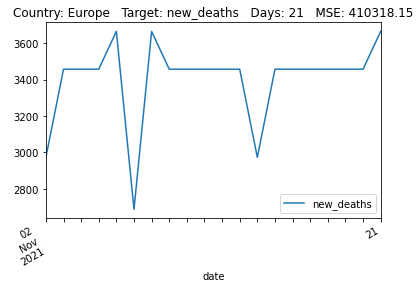

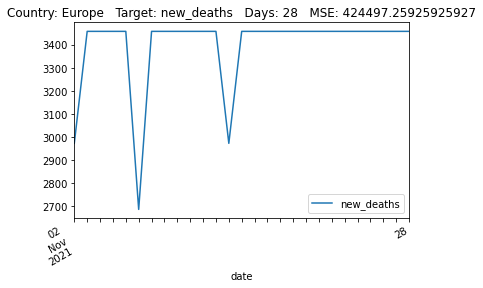

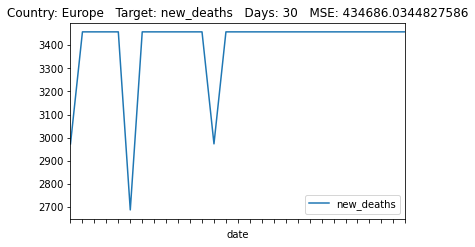

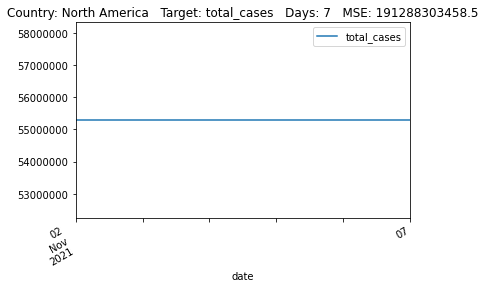

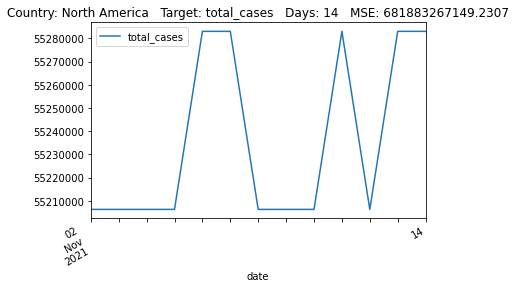

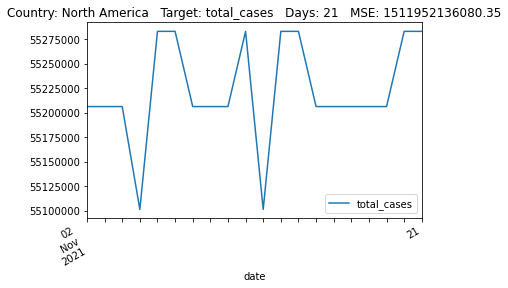

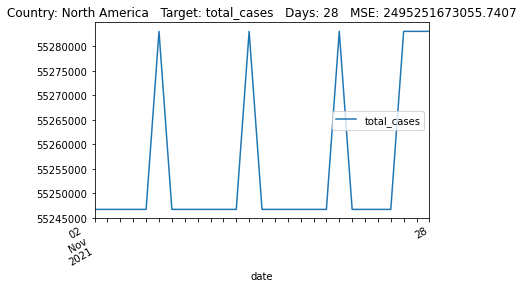

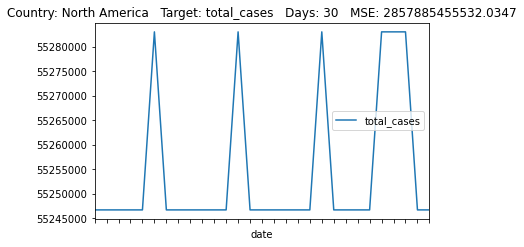

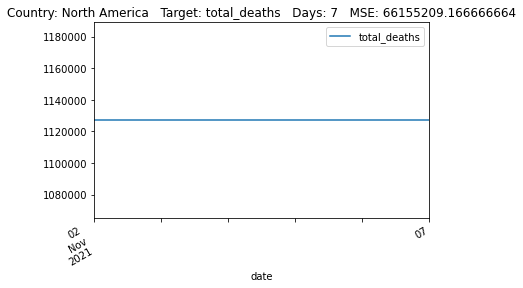

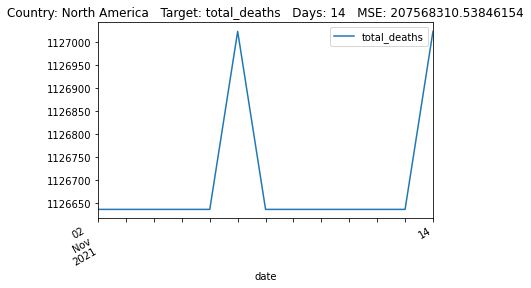

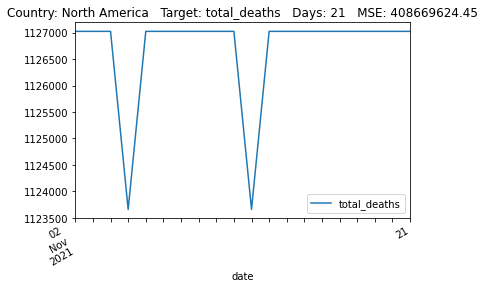

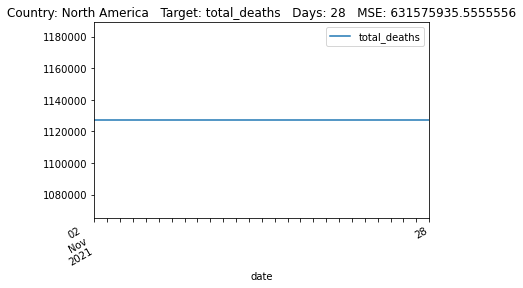

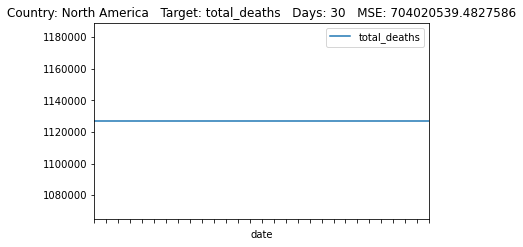

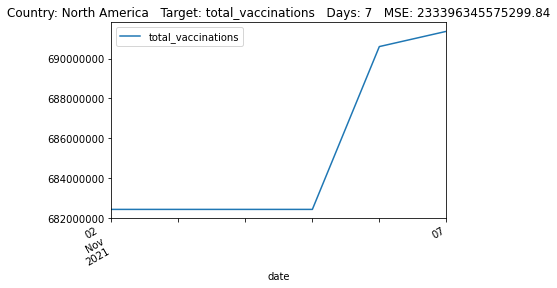

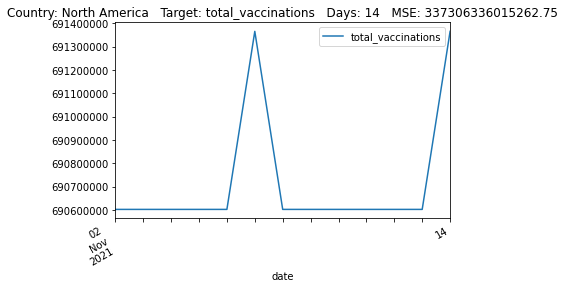

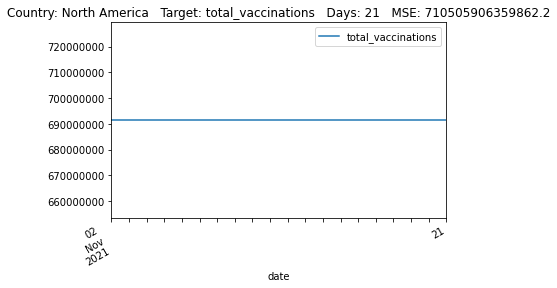

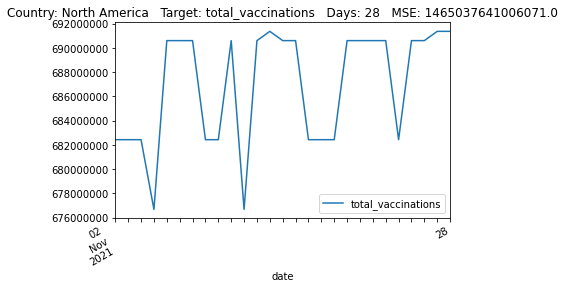

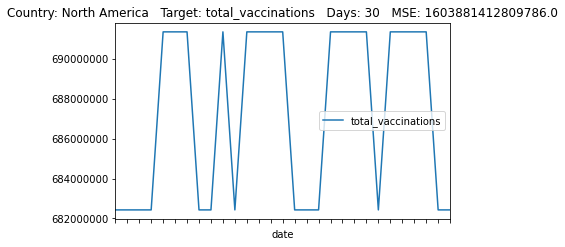

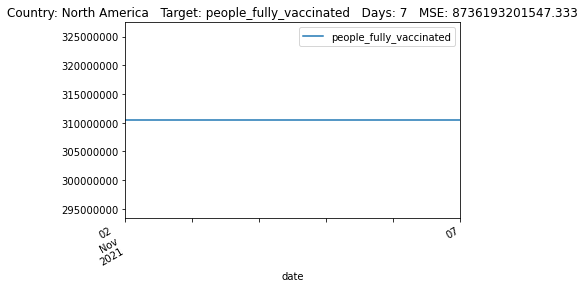

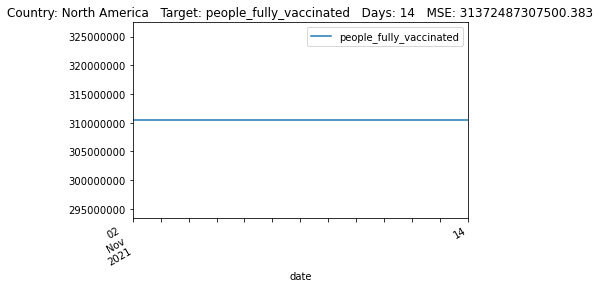

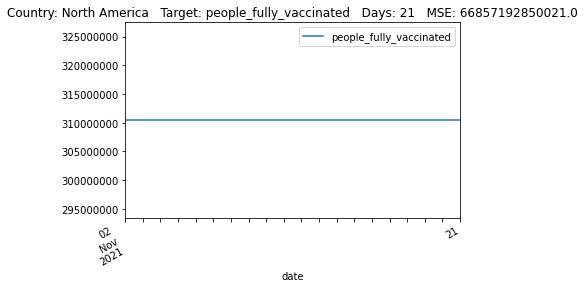

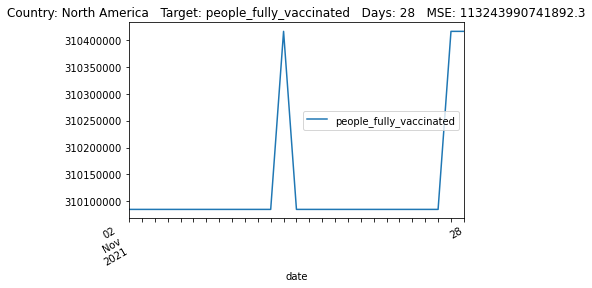

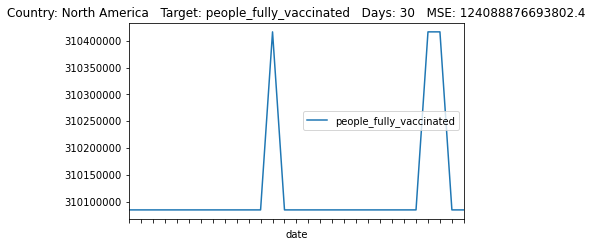

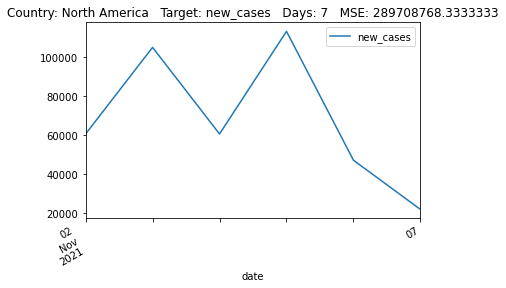

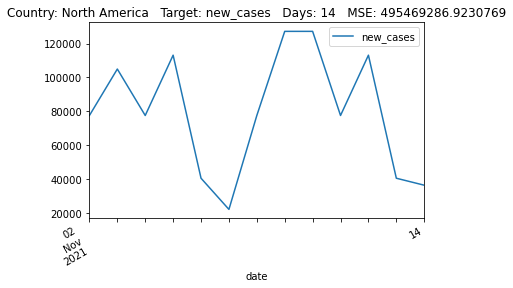

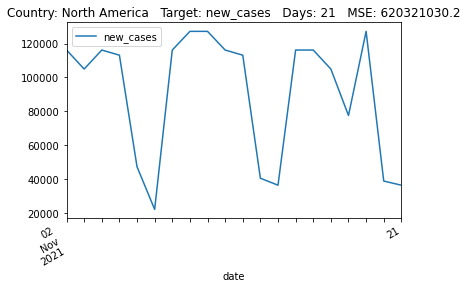

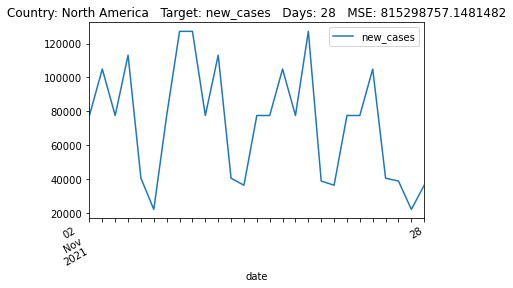

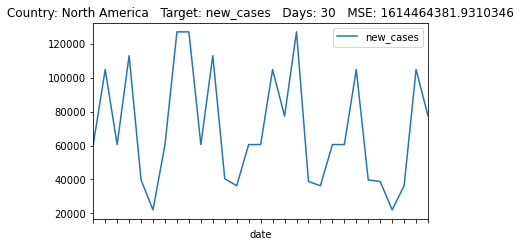

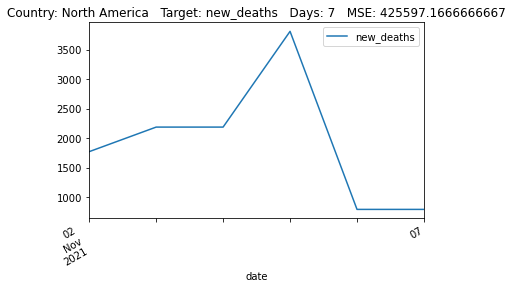

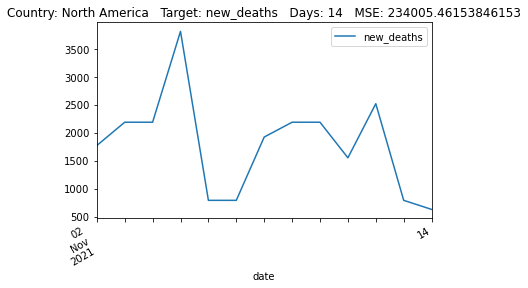

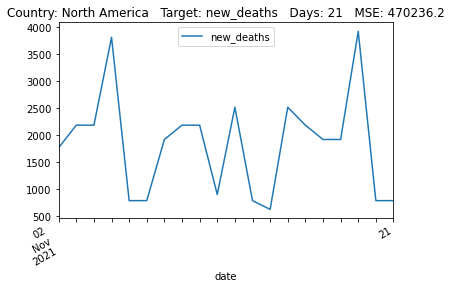

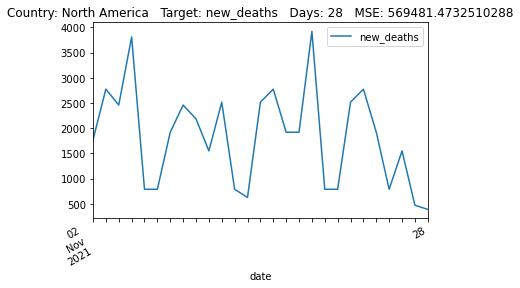

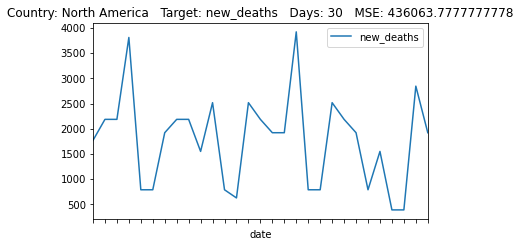

In [17]:
days = [7,14,21,28,30]
continents = {'Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'}
for continent in continents:
    for target in ['total_cases','total_deaths','total_vaccinations','people_fully_vaccinated','new_cases','new_deaths']:
        for day in days:
            tree_predict_country(continent,target,day)
